In [137]:
from torch.autograd import Variable
import torch.nn.functional as F

import torch
from torch import nn
import torch.tensor as Tensor
import torch.optim as optim


from Triangulation import *



%matplotlib inline

In [138]:
polygons=load_dataset('7_polygons.pkl')

In [139]:
polygons_reshaped=[]
for polygon in polygons:
    polygons_reshaped.append(polygon.reshape(1,2*7))

polygons_reshaped=np.array(polygons_reshaped)

In [140]:
polygons_reshaped=polygons_reshaped.reshape(polygons_reshaped.shape[0],1,2*7)

#polygons_reshaped=polygons_reshaped.reshape(polygons_reshaped.shape[0],2*12)

In [141]:
x_tensor=torch.from_numpy(polygons_reshaped).type(torch.FloatTensor)
x_variable,y_variable=Variable(x_tensor).cuda(),Variable(x_tensor).cuda()

In [146]:
# This auto encoder uses linear connections (Results may be the same as using PCA)
class simple_autoencoder(nn.Module):
        
    def __init__(self):
        super(simple_autoencoder,self).__init__()
        self.encoder=nn.Sequential(
        nn.Linear(2*12,12),
        nn.BatchNorm1d(12,momentum=0.5),
        nn.ReLU(True),
        nn.Linear(12,6),
        nn.BatchNorm1d(6,momentum=0.5),
        nn.ReLU(True),      
        nn.Linear(6,2),
        nn.BatchNorm1d(2,momentum=0.5),

        nn.ReLU(True),
            
        )
        
        self.decoder=nn.Sequential(
        nn.Linear(2,6),
        nn.BatchNorm1d(6,momentum=0.5),

        nn.ReLU(True),
        nn.Linear(6,12),
        nn.BatchNorm1d(12,momentum=0.5),

        nn.ReLU(True)    ,
        nn.Linear(12,2*12)
        )
    
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
    
    
    
    
    
# Convolutional autoencoder
class conv_autoencoder(nn.Module):
        
    def __init__(self):
        super(conv_autoencoder,self).__init__()
        self.encoder=nn.Sequential(
        nn.Conv1d(1,30,kernel_size=2,stride=2),# d 24->12 stride=2 , filters =3
        nn.ReLU(True),
        nn.Conv1d(30,600,kernel_size=2,stride=1),# d 12->6 stride=2, filters=6
        nn.ReLU(True),
        nn.Conv1d(600,2,kernel_size=6,stride=1),#d  6->1 stride=1 ,filters=2   
        )
        
        self.decoder=nn.Sequential(
        nn.ReLU(True),

        nn.ConvTranspose1d(2,600,kernel_size=6,stride=1),
        nn.ReLU(True),
        nn.ConvTranspose1d(600,300,kernel_size=2,stride=1),
        nn.ReLU(True),
        nn.ConvTranspose1d(300,1,kernel_size=2,stride=2),

        
        )
    
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [147]:
model=conv_autoencoder().cuda()

In [148]:

criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(
model.parameters(), lr=1e-4, weight_decay=1e-5)

In [149]:
model=model.cuda()
nb_of_epochs=4000
batch_size=int(x_variable.size(0)/10)
model.train()

for epoch in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = model(x_variable.narrow(0,b,batch_size))                
        loss = criterion(out, y_variable.narrow(0,b,batch_size))     
        sum_loss+=loss.data[0]

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    print(sum_loss/x_variable.size(0))
        


5.876580517578125
4.49729599609375
2.1850667602539064
0.8868205749511718
0.7426623779296875
0.70820361328125
0.6839828186035156
0.6793693542480469
0.6767006103515625
0.6756413818359375
0.6748087646484375
0.6740256286621094
0.6731517578125
0.6720369750976563
0.6706502685546875
0.6688459838867188
0.6664459350585937
0.6632261413574219
0.6589274475097656
0.6532849548339844
0.645982958984375
0.6369350952148437
0.6266072692871094
0.616315625
0.6079470153808594
0.6029228332519532
0.6008080932617188
0.5998474487304688
0.5990849060058594
0.5983993225097656
0.5977627990722656
0.5971379028320313
0.5965008850097656
0.5958615112304687
0.59521328125
0.5945861206054688
0.5939191528320312
0.5932093078613281
0.592517724609375
0.591770263671875
0.590993359375
0.5901551147460937
0.5892615539550782
0.5883211181640625
0.5873148315429687
0.5862550598144531
0.5851270751953125
0.5839325805664063
0.5826412658691407
0.5812702392578125
0.5797406555175781
0.5781012573242188
0.5763590515136718
0.5744937866210937
0

KeyboardInterrupt: 

In [150]:
model,x_variable=model.cpu(),x_variable.cpu()
model.eval()

conv_autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 30, kernel_size=(2,), stride=(2,))
    (1): ReLU(inplace)
    (2): Conv1d(30, 600, kernel_size=(2,), stride=(1,))
    (3): ReLU(inplace)
    (4): Conv1d(600, 2, kernel_size=(6,), stride=(1,))
  )
  (decoder): Sequential(
    (0): ReLU(inplace)
    (1): ConvTranspose1d(2, 600, kernel_size=(6,), stride=(1,))
    (2): ReLU(inplace)
    (3): ConvTranspose1d(600, 300, kernel_size=(2,), stride=(1,))
    (4): ReLU(inplace)
    (5): ConvTranspose1d(300, 1, kernel_size=(2,), stride=(2,))
  )
)

In [151]:
x_variable

Variable containing:
(  0  ,.,.) = 
  1.2144e+00 -3.7611e-03  4.3527e-01  ...  -1.1191e+00  6.0773e-01 -6.7368e-01

(  1  ,.,.) = 
  7.5948e-01 -2.7041e-01  2.7368e-01  ...  -8.5231e-01  3.8521e-01 -8.3622e-01

(  2  ,.,.) = 
  8.4495e-01 -1.5438e-02  4.5442e-01  ...  -1.0577e+00  7.2514e-01 -5.8645e-01
 ...  

(19997,.,.) = 
  7.8227e-01 -7.7490e-02  3.5144e-01  ...  -7.7372e-01  4.8899e-01 -6.0974e-01

(19998,.,.) = 
  7.4771e-01 -1.1872e-01  2.9135e-01  ...  -8.5790e-01  5.4161e-01 -9.4875e-01

(19999,.,.) = 
  9.2310e-01 -2.3932e-02  5.4168e-01  ...  -8.8124e-01  7.2238e-01 -1.0617e+00
[torch.FloatTensor of size 20000x1x14]

In [152]:
polygon_prediction=model(x_variable)
polygon_prediction=polygon_prediction[89].data.cpu()
polygon_prediction=polygon_prediction.numpy()
polygon_prediction=polygon_prediction.reshape(7,2)

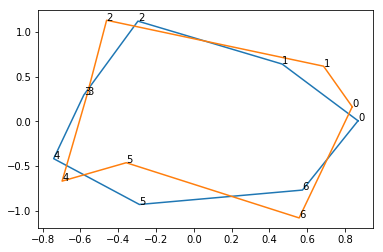

In [153]:
plot_contour(polygon_prediction)
plot_contour(polygons[89])

In [657]:
help(nn.Conv1d)

Help on class Conv1d in module torch.nn.modules.conv:

class Conv1d(_ConvNd)
 |  Applies a 1D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{in}, L)` and output :math:`(N, C_{out}, L_{out})` can be
 |  precisely described as:
 |  
 |  .. math::
 |  
 |      \begin{array}{ll}
 |      out(N_i, C_{out_j})  = bias(C_{out_j})
 |                     + \sum_{{k}=0}^{C_{in}-1} weight(C_{out_j}, k)  \star input(N_i, k)
 |      \end{array}
 |  
 |  where :math:`\star` is the valid `cross-correlation`_ operator,
 |  :math:`N` is a batch size, :math:`C` denotes a number of channels,
 |  :math:`L` is a length of signal sequence.
 |  
 |  | :attr:`stride` controls the stride for the cross-correlation, a single
 |    number or a one-element tuple.
 |  | :attr:`padding` controls the amount of implicit zero-paddings on both
 |  |  sides for :attr:`padding` number of points.
 |  | :attr

In [25]:
polygon_prediction

array([[ 0.97967017,  0.00463816],
       [ 0.84873545,  0.50282168],
       [ 0.38454553,  0.68619001],
       [-0.00177162,  0.84484351],
       [-0.40613338,  0.69851059],
       [-0.9370811 ,  0.56263232],
       [-0.90546513,  0.00325594],
       [-0.76080012, -0.44539672],
       [-0.39749897, -0.67931378],
       [ 0.00169786, -0.92938364],
       [ 0.49300653, -0.82771182],
       [ 0.70441866, -0.41366461]], dtype=float32)

Help on class BatchNorm1d in module torch.nn.modules.batchnorm:

class BatchNorm1d(_BatchNorm)
 |  Applies Batch Normalization over a 2d or 3d input that is seen as a
 |  mini-batch.
 |  
 |  .. math::
 |  
 |      y = \frac{x - mean[x]}{ \sqrt{Var[x] + \epsilon}} * gamma + beta
 |  
 |  The mean and standard-deviation are calculated per-dimension over
 |  the mini-batches and gamma and beta are learnable parameter vectors
 |  of size C (where C is the input size).
 |  
 |  During training, this layer keeps a running estimate of its computed mean
 |  and variance. The running sum is kept with a default momentum of 0.1.
 |  
 |  During evaluation, this running mean/variance is used for normalization.
 |  
 |  Because the BatchNorm is done over the `C` dimension, computing statistics
 |  on `(N, L)` slices, it's common terminology to call this Temporal BatchNorm
 |  
 |  Args:
 |      num_features: num_features from an expected input of size
 |          `batch_size x num_features [x widt

Help on class BatchNorm1d in module torch.nn.modules.batchnorm:

class BatchNorm1d(_BatchNorm)
 |  Applies Batch Normalization over a 2d or 3d input that is seen as a
 |  mini-batch.
 |  
 |  .. math::
 |  
 |      y = \frac{x - mean[x]}{ \sqrt{Var[x] + \epsilon}} * gamma + beta
 |  
 |  The mean and standard-deviation are calculated per-dimension over
 |  the mini-batches and gamma and beta are learnable parameter vectors
 |  of size C (where C is the input size).
 |  
 |  During training, this layer keeps a running estimate of its computed mean
 |  and variance. The running sum is kept with a default momentum of 0.1.
 |  
 |  During evaluation, this running mean/variance is used for normalization.
 |  
 |  Because the BatchNorm is done over the `C` dimension, computing statistics
 |  on `(N, L)` slices, it's common terminology to call this Temporal BatchNorm
 |  
 |  Args:
 |      num_features: num_features from an expected input of size
 |          `batch_size x num_features [x widt

In [123]:
x=Variable(torch.FloatTensor([[[0,0,3]]]))
x.shape

torch.Size([1, 1, 3])

In [478]:
x_variable.shape

torch.Size([60000, 1, 24])

In [153]:
m = nn.Conv1d(in_channels=1,out_channels=2,kernel_size=2)
x_variable=x_variable.cpu()

In [154]:
m(x)

Variable containing:
(0 ,.,.) = 
  0.2492 -1.6630
  0.1763  0.8156
[torch.FloatTensor of size 1x2x2]

In [155]:
x_variable.shape

torch.Size([60000, 1, 24])

In [23]:
m = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=13)

In [24]:
m(x_variable)

RuntimeError: Input type (CUDAFloatTensor) and weight type (CPUFloatTensor) should be the same

In [25]:
func=nn.ReLU()

In [26]:
func(m(x))

NameError: name 'x' is not defined

In [27]:
x_variable=x_variable.cuda()


In [28]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(24, 14)
        self.fc21 = nn.Linear(14, 2)
        self.fc22 = nn.Linear(14, 2)
        self.fc3 = nn.Linear(2, 14)
        self.fc4 = nn.Linear(14, 24)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.BCELoss()


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


In [29]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
nb_of_epochs=4000
batch_size=int(x_variable.size(0)/10)

for epoch in range(nb_of_epochs):
    model.train()
    train_loss=0

    for b in range(0,x_variable.size(0),batch_size):
        recon_batch,mu,logvar = model(x_variable.narrow(0,b,batch_size))                
        loss = loss_function(recon_batch, y_variable.narrow(0,b,batch_size),mu,logvar)     
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        train_loss+=loss.data[0]
    print(train_loss/x_variable.size(0))
        

0.08427379811604818
0.05906171976725261
0.042195732879638674
0.02583740832010905
0.012065117899576823
0.003920155477523803
0.0017312102317810058
0.0017457127412160238
0.0014478217919667562
0.0011840258439381917
0.0010786115248998006
0.0009954208215077719
0.0009241549412409465
0.0008680975914001465
0.0008176822662353516
0.0007710820436477661
0.0007279782851537069
0.000687526289621989
0.0006492488662401835
0.0006128788749376932
0.00057838667233785
0.0005447821577390034
0.0005132324814796448
0.0004823383053143819
0.00045259085496266685
0.0004236271778742472
0.0003961742361386617
0.0003692155043284098
0.00034255663951237995
0.0003169219692548116
0.00029175037145614624
0.00026713016231854757
0.00024306388894716898
0.00021923057238260906
0.00019581817785898844
0.00017181203365325927
0.00014876575271288554
0.0001262182076772054
0.00010323645273844401
8.076347708702088e-05
5.763450264930725e-05
3.502514958381653e-05
1.3118181626001994e-05
-9.948378801345826e-06
-3.226481874783834e-05
-5.516081

-0.0012515852053960165
-0.0012516491492589315
-0.0012517378568649292
-0.0012517849524815877
-0.0012518394072850545
-0.001251940401395162
-0.0012519787073135375
-0.0012520352840423583
-0.0012521003246307374
-0.0012521643002827963
-0.0012522292455037435
-0.001252248771985372
-0.001252344552675883
-0.001252402949333191
-0.0012524743239084879
-0.00125256343682607
-0.0012526012182235717
-0.001252672553062439
-0.001252714236577352
-0.0012528040409088134
-0.0012528634309768676
-0.001252859934171041
-0.0012529809554417928
-0.0012529974301656087
-0.0012530914862950643
-0.0012531592766443888
-0.0012532113472620645
-0.0012532693703969319
-0.0012533439874649048
-0.0012533462444941203
-0.0012534990946451822
-0.0012535181522369385
-0.0012535861571629841
-0.0012536409457524617
-0.0012537391185760498
-0.0012537651062011718
-0.0012538124561309815
-0.001253877862294515
-0.0012539216041564942
-0.0012539740800857544
-0.0012540358622868855
-0.0012541396220525107
-0.001254183602333069
-0.001254201873143514


-0.001260905392964681
-0.001260707139968872
-0.0012610512653986614
-0.0012611152410507201
-0.0012611063559850057
-0.0012611244678497314
-0.0012611426671346028
-0.0012611341794331868
-0.0012611191511154175
-0.0012605311632156373
-0.0012606348911921184
-0.0012609764337539672
-0.0012611244837443035
-0.0012611381928126018
-0.0012611489216486614
-0.0012611704508463542
-0.0012611680269241333
-0.001261158299446106
-0.0012611669858296711
-0.0012611825704574584
-0.001261122194925944
-0.0012606677214304605
-0.0012608527898788453
-0.0012610427618026734
-0.001261119786898295
-0.0012611679633458455
-0.0012611983140309651
-0.001261160675684611
-0.0012611855824788412
-0.0012611587603886922
-0.0012609032074610393
-0.0012607102553049724
-0.0012610742966334026
-0.0012611283699671427
-0.0012611643075942994
-0.0012612041234970092
-0.001261186401049296
-0.0012611685037612916
-0.0012610745747884114
-0.0012607531706492106
-0.001261076283454895
-0.0012611297448476156
-0.0012611671288808187
-0.0012611610968907

-0.0012613094886144002
-0.001261136031150818
-0.001260197377204895
-0.001261032287279765
-0.0012612074851989746
-0.0012612823804219564
-0.001261323595046997
-0.001261323062578837
-0.0012613223393758137
-0.001261320988337199
-0.0012613139073053997
-0.001261317459742228
-0.0012613213936487834
-0.001261318604151408
-0.0012611668904622395
-0.0012603310664494832
-0.0012610600471496581
-0.0012612011671066284
-0.0012612761815388998
-0.001261309774716695
-0.0012613171497980753
-0.0012613224903742473
-0.0012613208293914796
-0.0012613160928090414
-0.0012613259792327882
-0.0012613160451253255
-0.001261288046836853
-0.0012606056769688923
-0.0012605525175730388
-0.0012609931071599324
-0.0012612492481867473
-0.0012612878640492757
-0.0012613258679707844
-0.0012613147894541422
-0.0012613333145777385
-0.0012613056818644205
-0.0012613064527511597
-0.0012612211624781291
-0.0012611501534779866
-0.0012612662076950073
-0.0012613113641738892
-0.0012612822612126668
-0.0012610477606455484
-0.001260719648996989

-0.0012612590471903482
-0.0012612995306650798
-0.0012613062461217244
-0.0012613162438074748
-0.0012613253672917684
-0.0012613165775934856
-0.001261293363571167
-0.0012612084070841472
-0.0012612086137135823
-0.0012601007143656412
-0.0012609589417775472
-0.0012611823558807372
-0.001261256488164266
-0.001261318532625834
-0.0012613117297490437
-0.001261312182744344
-0.001261317213376363
-0.0012613161166508992
-0.0012613185405731201
-0.0012613207896550497
-0.001261246697107951
-0.0012611839294433594
-0.001261250376701355
-0.001261194602648417
-0.0012608324845631918
-0.0012612077713012695
-0.001261226757367452
-0.0012612683216730754
-0.001261312953631083
-0.0012613171418507894
-0.0012613040844599405
-0.0012613099654515585
-0.0012611323753992717
-0.0012605317831039429
-0.0012610722541809081
-0.0012612220684687296
-0.0012612616856892904
-0.0012613168795903523
-0.0012613245248794555
-0.0012613173007965089
-0.00126131645043691
-0.0012611375013987223
-0.0012612433513005574
-0.0012612956126530966


-0.00126132230758667
-0.0012613242467244465
-0.0012612505197525025
-0.0012612372716267904
-0.0012612959782282512
-0.0012613145430882772
-0.0012612889528274536
-0.001260586134592692
-0.001260830775896708
-0.0012611480156580607
-0.001261268162727356
-0.0012613110701243083
-0.0012613127390543619
-0.001261324644088745
-0.0012613219102223714
-0.0012612838347752888
-0.0012611372788747153
-0.0012612641016642252
-0.001261299188931783
-0.0012613286018371582
-0.0012613211790720622
-0.0012612303733825683
-0.0012598822673161824
-0.0012609342575073243
-0.0012611198027928671
-0.0012612773100535075
-0.0012613057295481364
-0.0012613277355829876
-0.0012613182226816812
-0.0012613306999206544
-0.0012613273779551188
-0.001261326003074646
-0.00126131698290507
-0.0012613252639770507
-0.0012613234122594197
-0.0012611978689829508
-0.0012610707521438598
-0.0012612746556599935
-0.001261302391688029
-0.0012613036553064982
-0.0012609695990880331
-0.001260546056429545
-0.001261091430981954
-0.0012612316528956096
-

-0.0012609307924906412
-0.001261154596010844
-0.0012612628936767578
-0.0012613080422083536
-0.0012613234599431356
-0.0012613284349441529
-0.0012613274892171223
-0.0012613071839014688
-0.0012612229665120442
-0.0012612976710001628
-0.0012613118171691895
-0.0012613263448079427
-0.0012612101475397745
-0.0012603353182474772
-0.0012610674937566122
-0.0012612205823262532
-0.001261284327507019
-0.0012613110383351645
-0.0012613258679707844
-0.0012613110939661662
-0.001261186973253886
-0.0012612725496292114
-0.0012613144000371296
-0.0012613158305486043
-0.001261317483584086
-0.0012613219340642293
-0.0012612482865651448
-0.0012604036569595336
-0.0012610119422276815
-0.0012612060546875
-0.001261290661493937
-0.0012613076368967692
-0.0012613235553105672
-0.0012613148848215738
-0.001261224627494812
-0.0012611441214879354
-0.0012612680276234945
-0.0012613101720809936
-0.001261316688855489
-0.0012613155682881672
-0.0012612932205200195
-0.0012605411211649576
-0.0012606868346532185
-0.001261133662859598

-0.0012613115549087524
-0.0012613178888956705
-0.0012613197882970174
-0.0012613301436106364
-0.0012613109668095906
-0.0012611867348353068
-0.0012606117645899454
-0.0012611302216847737
-0.0012612404664357503
-0.0012612911144892374
-0.001261311133702596
-0.0012612740993499757
-0.0012611730972925822
-0.0012612815539042154
-0.001261314328511556
-0.0012613221486409505
-0.0012613202889760334
-0.001261206038792928
-0.0012603111743927002
-0.0012610543966293335
-0.0012612123886744182
-0.00126127982934316
-0.0012613084236780803
-0.0012613203525543213
-0.0012613226334253947
-0.0012613213698069255
-0.0012613263765970865
-0.0012612011273701986
-0.0012612414280573528
-0.0012613024870554606
-0.001261321512858073
-0.0012613263686498007
-0.0012611411809921264
-0.001260328205426534
-0.0012610622485478718
-0.0012612097342809042
-0.0012612936894098917
-0.0012613146543502807
-0.0012613255500793458
-0.0012613184611002604
-0.0012613203128178914
-0.001261324683825175
-0.001261290454864502
-0.00126114755471547

-0.001260442344347636
-0.001260753830273946
-0.0012611632347106934
-0.001261281402905782
-0.0012612974484761555
-0.001261326281229655
-0.0012613248348236083
-0.0012613245884577433
-0.0012612071752548218
-0.001261242135365804
-0.0012613020817438762
-0.0012613224267959595
-0.0012613162358601888
-0.001261323356628418
-0.0012613229433695475
-0.0012613219817479452
-0.0012612706661224366
-0.0012598430554072062
-0.0012608863512674968
-0.001261100713411967
-0.0012612737735112507
-0.0012613013505935668
-0.0012613118251164753
-0.0012613148848215738
-0.0012613292773564658
-0.0012612456639607748
-0.0012612209558486938
-0.0012612945079803466
-0.0012613229115804037
-0.0012613253752390544
-0.0012613206307093303
-0.0012613213141759237
-0.0012613224744796752
-0.0012613206386566161
-0.001261322037378947
-0.001261323912938436
-0.0012612871328989664
-0.0012605288902918497
-0.0012606920878092448
-0.0012611257155736287
-0.0012612743616104126
-0.0012612953344980876
-0.001261312222480774
-0.001261321473121643

-0.0012612836440404256
-0.0012613191445668538
-0.0012613165855407714
-0.0012613198757171632
-0.001261322331428528
-0.0012613214095433553
-0.0012613236506779989
-0.0012613121668497722
-0.001260781208674113
-0.001260355814297994
-0.0012610487143198648
-0.0012612608353296916
-0.001261295509338379
-0.0012613194783528646
-0.0012613212664922078
-0.0012612931648890177
-0.001261217427253723
-0.0012612971544265748


In [22]:
model,x_variable=model.cuda(),x_variable.cuda()
model.eval()
model,x_variable

(VAE(
   (fc1): Linear(in_features=24, out_features=14, bias=True)
   (fc21): Linear(in_features=14, out_features=2, bias=True)
   (fc22): Linear(in_features=14, out_features=2, bias=True)
   (fc3): Linear(in_features=2, out_features=14, bias=True)
   (fc4): Linear(in_features=14, out_features=24, bias=True)
 ), Variable containing:
 (  0  ,.,.) = 
   7.2590e-01  1.7160e-01  8.4208e-01  ...  -8.6179e-01  6.2929e-01 -2.9497e-01
 
 (  1  ,.,.) = 
   1.1056e+00  8.5052e-02  1.0595e+00  ...  -8.8101e-01  5.4964e-01 -4.5626e-01
 
 (  2  ,.,.) = 
   1.3043e+00 -1.6374e-01  7.1454e-01  ...  -1.0654e+00  3.5652e-01 -3.6640e-01
  ...  
 
 (59997,.,.) = 
   1.0052e+00  1.3537e-01  7.4466e-01  ...  -8.4981e-01  6.0202e-01 -5.4357e-01
 
 (59998,.,.) = 
   7.9475e-01 -1.6893e-01  4.9571e-01  ...  -4.6446e-01  1.2147e+00 -5.7865e-01
 
 (59999,.,.) = 
   1.3487e+00  1.5864e-02  7.7996e-01  ...  -4.4117e-01  5.4940e-01 -2.1820e-01
 [torch.cuda.FloatTensor of size 60000x1x24 (GPU 0)])

In [20]:
polygon_prediction=model(x_variable)
polygon_prediction=polygon_prediction[14].data.cpu()
polygon_prediction=polygon_prediction.numpy()
polygon_prediction=polygon_prediction.reshape(12,2)

plot_contour(polygon_prediction)
plot_contour(polygons[14])

RuntimeError: Expected object of type Variable[torch.cuda.FloatTensor] but found type Variable[torch.FloatTensor] for argument #1 'other'

In [18]:
model,x_variable

(VAE(
   (fc1): Linear(in_features=24, out_features=14, bias=True)
   (fc21): Linear(in_features=14, out_features=2, bias=True)
   (fc22): Linear(in_features=14, out_features=2, bias=True)
   (fc3): Linear(in_features=2, out_features=14, bias=True)
   (fc4): Linear(in_features=14, out_features=24, bias=True)
 ), Variable containing:
 (  0  ,.,.) = 
   7.2590e-01  1.7160e-01  8.4208e-01  ...  -8.6179e-01  6.2929e-01 -2.9497e-01
 
 (  1  ,.,.) = 
   1.1056e+00  8.5052e-02  1.0595e+00  ...  -8.8101e-01  5.4964e-01 -4.5626e-01
 
 (  2  ,.,.) = 
   1.3043e+00 -1.6374e-01  7.1454e-01  ...  -1.0654e+00  3.5652e-01 -3.6640e-01
  ...  
 
 (59997,.,.) = 
   1.0052e+00  1.3537e-01  7.4466e-01  ...  -8.4981e-01  6.0202e-01 -5.4357e-01
 
 (59998,.,.) = 
   7.9475e-01 -1.6893e-01  4.9571e-01  ...  -4.6446e-01  1.2147e+00 -5.7865e-01
 
 (59999,.,.) = 
   1.3487e+00  1.5864e-02  7.7996e-01  ...  -4.4117e-01  5.4940e-01 -2.1820e-01
 [torch.FloatTensor of size 60000x1x24])